<a href="https://colab.research.google.com/github/nimu77/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
column_names = ['party', 'handicapped_infants', 'water_project_cost_sharing', 'adoption_of_budget_resolution', 'physician_fee_freeze', 'el_salvador_aid', 
                'religious_groups_in_schools', 'anti_satellite_test_ban', 'aid_to_nicaraguan_contras', 'mx_missile', 'immigration', 'synfuels_corporation_cutback', 
                'education_spending', 'superfund_right_to_sue', 'crime', 'duty_free_exports', 'export_administration_act_southafrica']

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', names=column_names)
print(df.shape)
df.head()

(435, 17)


,party,handicapped_infants,water_project_cost_sharing,adoption_of_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_southafrica
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [11]:
df = df.replace({'y': 1, 'n': 0, '?': np.NaN})
df.head()

,party,handicapped_infants,water_project_cost_sharing,adoption_of_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_southafrica
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
dem = df[df['party'] == 'democrat']
rep = df[df['party'] == 'republican']

In [13]:
dem.head()

,party,handicapped_infants,water_project_cost_sharing,adoption_of_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_southafrica
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


In [15]:
dem['physician_fee_freeze'].value_counts(dropna=False)

0.0    245
1.0     14
NaN      8
Name: physician_fee_freeze, dtype: int64

In [16]:
dem_physician = dem[['party', 'physician_fee_freeze']]
dem_physician.head()

,party,physician_fee_freeze
2,democrat,NaN
3,democrat,0.0
4,democrat,0.0
5,democrat,0.0
6,democrat,1.0


In [18]:
dem_physician.describe()

,physician_fee_freeze
count,259.000000
mean,0.054054
std,0.226562
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [0]:
dem_physician = dem_physician.dropna()

In [22]:
dem_physician.isnull().sum()

party                   0
physician_fee_freeze    0
dtype: int64

In [24]:
dem_physician['physician_fee_freeze'].value_counts(dropna=False)

0.0    245
1.0     14
Name: physician_fee_freeze, dtype: int64

In [17]:
dem_physician['physician_fee_freeze'].mean()

0.05405405405405406

In [0]:
from scipy.stats import t, stats

In [0]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  sample = np.array(data)
  # SAMPLE standard deviation: s
  s = np.std(sample, ddof=1)
  # Sample Size
  n = len(sample)
  standard_error = s / np.sqrt(n)
  t_dist = t.ppf((1 + confidence) / 2, n-1)
  margin_of_error = t_dist*standard_error
  x_bar = np.mean(sample)
  lower_bound = x_bar - margin_of_error
  upper_bound = x_bar + margin_of_error
  return (lower_bound, x_bar, upper_bound)

In [42]:
confidence_interval(dem_physician['physician_fee_freeze'], confidence=0.95)

(0.02633186149720885, 0.05405405405405406, 0.08177624661089927)

In [0]:
lower, mean, upper = confidence_interval(dem_physician['physician_fee_freeze'])

In [47]:
print(lower)
print(mean)
upper

0.02633186149720885
0.05405405405405406


0.08177624661089927

In [0]:
moe = mean - lower

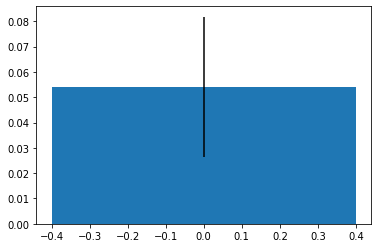

In [50]:
plt.bar(0, mean, yerr=moe)
plt.title("Estimated level of democrats support for physician fee freeze bills")
plt.show()

#### - Confidennce Intervals here interprets the estimation of average support from democrat for that specific bill.

## Chi-squared test

In [51]:
from google.colab import files
uploaded = files.upload()

Saving adult.data to adult.data


In [70]:
adult = pd.read_csv('adult.data', names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                                         'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
                                         'hours-per-week', 'native-country', 'income'], skipinitialspace=True, na_values='?')
print(adult.shape)
adult.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [71]:
adult.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [72]:
adult['education'][0]

'Bachelors'

In [112]:
observed = pd.crosstab(adult['sex'], adult['income'])
observed

income,<=50K,>50K
sex,,
Female,9592,1179
Male,15128,6662


In [113]:
observed_margin = pd.crosstab(adult['sex'], adult['income'], margins=True)
observed_margin

income,<=50K,>50K,All
sex,,,
Female,9592,1179,10771
Male,15128,6662,21790
All,24720,7841,32561


In [114]:
row_sums = observed_margin.iloc[0:2, 2:].values
row_sums = row_sums.T[0]
row_sums

array([10771, 21790])

In [115]:
column_sums = observed_margin.iloc[2:, 0:2].values
column_sums = column_sums[0]
column_sums

array([24720,  7841])

In [116]:
total_t = adult.shape[0]
total_t

32561

In [117]:
expected = []
for i in range(len(row_sums)):
  expected_row=[]
  for column in column_sums:
    expected_val = column*row_sums[i]/total_t
    expected_row.append(expected_val)
  expected.append(expected_row)

expected = np.array(expected)
print(expected.shape)
print(expected)

(2, 2)
[[ 8177.24025675  2593.75974325]
 [16542.75974325  5247.24025675]]


In [121]:
chi2 = ((observed-expected)**2 / expected).sum().sum()
chi2

1518.8868199570725

#### - dof is 4.

## Run chi-square test using scipy

In [0]:
from scipy.stats import chi2_contingency

In [122]:
chi2_contingency(observed)

(1517.813409134445, 0.0, 1, array([[ 8177.24025675,  2593.75974325],
        [16542.75974325,  5247.24025675]]))

#### Conclusion: Looking at t-stats and p-value, we can reject the null hypothesis and suggest the alternative that there is association between sex and income.

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)